
Missing values after cleaning:
Date             0
Pharmacy         0
Location         0
Drug             0
Brand            0
Price            0
Quantity         0
Supplier_Name    0
Batch_Number     0
Expiry_Date      0
Sales_Channel    0
Drug_Form        0
dtype: int64


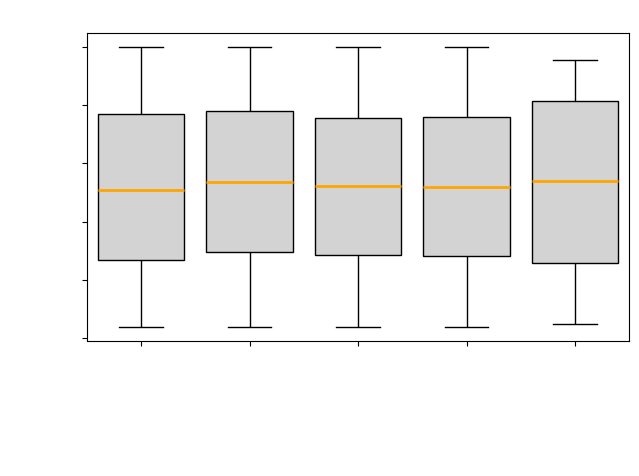

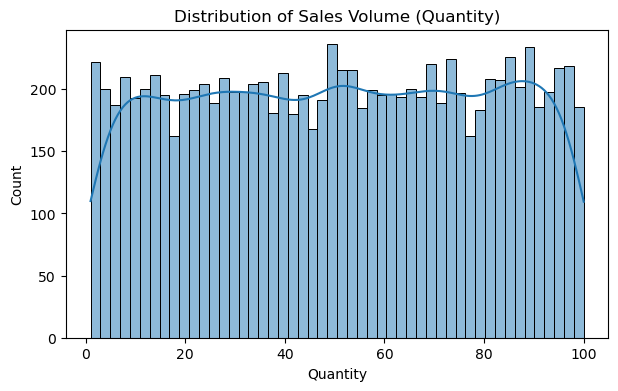

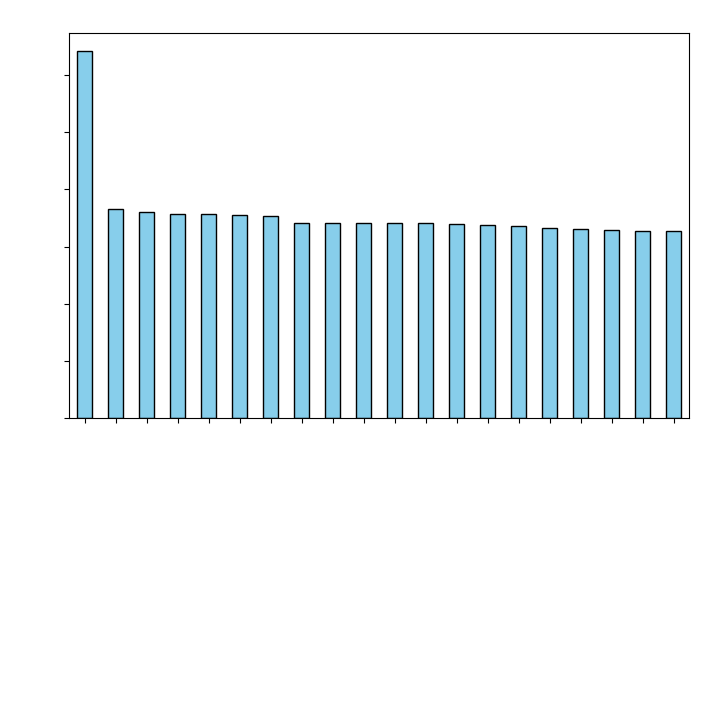


Rare brands (fewer than 10 transactions):
Brand
Unknown    8
Name: count, dtype: int64


C:\Users\tech\AppData\Local\Temp\ipykernel_2296\1210201719.py:136: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Location', data=df, palette="Set2", edgecolor="black")


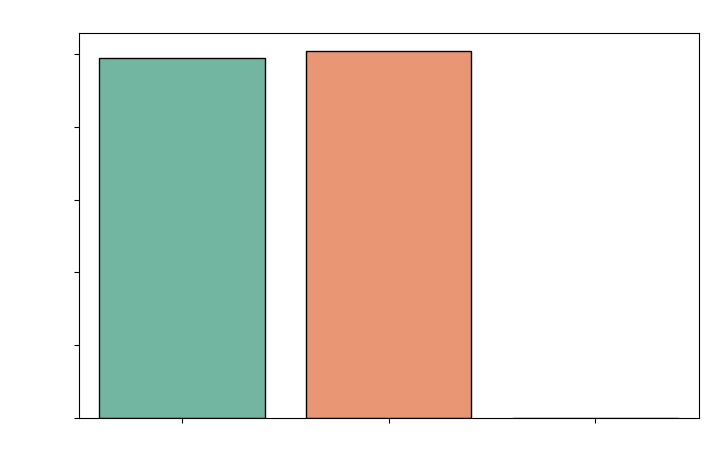

✅ EDA & Cleaning Completed


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ----------------------------
# 1. Load dataset
# ----------------------------
df = pd.read_csv(r"C:\Users\tech\Downloads\pharmacy_sales_analytics - pharmacy_sales_analytics.csv") 

# Preview
#print(df.head())
#print(df.info())

# ----------------------------
# 2. Data Cleaning
# ----------------------------
# Convert dates
def parse_dates(series):
    parsed = pd.Series([pd.NaT] * len(series), index=series.index)
    
    # List of possible formats in your dataset
    formats = ["%Y-%m-%d", "%d/%m/%Y", "%m/%d/%Y", "%B %Y"]
    
    for fmt in formats:
        try:
            mask = parsed.isna()  # only try parsing those not yet converted
            parsed.loc[mask] = pd.to_datetime(series[mask], format=fmt, errors="coerce")
        except Exception as e:
            print(f"Skipping format {fmt}: {e}")
    
    return parsed

# Apply to your dataframe
df["Date"] = parse_dates(df["Date"])
df["Expiry_Date"] = parse_dates(df["Expiry_Date"])

# Handle missing categorical values
for col in ['Pharmacy', 'Drug', 'Brand', 'Supplier_Name', 'Location']:
    df[col] = df[col].fillna("Unknown")

# Handle missing numeric values
for col in ['Price', 'Quantity']:
    df[col] = df[col].fillna(df[col].median())

# Create a mapping dictionary for brand name corrections
brand_corrections = {
    "Biokare": "BioCare",
    "Biocare": "BioCare",
    "FarmaTrust": "PharmaTrust",
    "PharmaTrust": "PharmaTrust",
    "MediPluz": "MediPlus",
    "MediPlus": "MediPlus",
    "Hea1thFirst": "HealthFirst",
    "HealthFirst": "HealthFirst"
}

# Apply corrections (case-insensitive)
df["Brand"] = df["Brand"].replace(brand_corrections)

# Drop rows where Date is missing (NaT or NaN)
df = df.dropna(subset=["Date"])

# Reset index after dropping
df = df.reset_index(drop=True)

# ----------------------------
# 3. Missing values summary
# ----------------------------
print("\nMissing values after cleaning:")
print(df.isnull().sum())

# ----------------------------
# 4. Exploratory Data Analysis
# ----------------------------
# Price distribution by Brand
plt.figure(figsize=(7, 4), facecolor="none")  # transparent background

# Custom boxplot colors (light grey boxes with black edges)
sns.boxplot(
    data=df, 
    x='Brand', 
    y='Price', 
    boxprops=dict(facecolor="lightgrey", edgecolor="black"),
    medianprops=dict(color="orange", linewidth=2),  # highlight medians in orange
    whiskerprops=dict(color="black"),
    capprops=dict(color="black"),
    flierprops=dict(markerfacecolor="red", markeredgecolor="red", markersize=3)
)

# White + bold text for visibility on blue background
plt.xticks(rotation=45, color="white", fontsize=12, fontweight="bold")
plt.yticks(color="white", fontsize=12, fontweight="bold")
plt.title("Price Distribution by Brand", color="white", fontsize=14, fontweight="bold")
plt.xlabel("Brand", color="white", fontsize=12, fontweight="bold")
plt.ylabel("Price", color="white", fontsize=12, fontweight="bold")

# Save with transparent background
plt.savefig("Price_distribution_by_Brand.png", dpi=300, bbox_inches="tight", transparent=True)
plt.show()


# Sales volumes by Pharmacy
plt.figure(figsize=(7,4))
sns.histplot(df['Quantity'], bins=50, kde=True)
plt.title("Distribution of Sales Volume (Quantity)")
plt.savefig("distribution of sales volume.png", dpi=300, bbox_inches="tight")
plt.show()

# ----------------------------
# Sales volume by Supplier
# ----------------------------
plt.figure(figsize=(8, 5), facecolor="none")
df['Supplier_Name'].value_counts().head(20).plot(
    kind='bar', color="skyblue", edgecolor="black"
)
plt.title("Top 20 Suppliers by Transaction Count", color="white", fontsize=14, fontweight="bold")
plt.xlabel("Supplier", color="white", fontsize=12, fontweight="bold")
plt.ylabel("Count", color="white", fontsize=12, fontweight="bold")
plt.xticks(rotation=75, color="white", fontsize=10, fontweight="bold")
plt.yticks(color="white", fontsize=10, fontweight="bold")
plt.savefig("Top_20_suppliers_by_transactions_counts.png", dpi=300, bbox_inches="tight", transparent=True)
plt.show()

# Rare brands
brand_counts = df['Brand'].value_counts()
rare_brands = brand_counts[brand_counts < 10]
print("\nRare brands (fewer than 10 transactions):")
print(rare_brands)

# ----------------------------
# Urban vs Rural differences
# ----------------------------
if 'Location' in df.columns:
    plt.figure(figsize=(8, 5), facecolor="none")
    sns.countplot(x='Location', data=df, palette="Set2", edgecolor="black")
    plt.title("Transactions by Location (Urban vs Rural)", color="white", fontsize=14, fontweight="bold")
    plt.xlabel("Location", color="white", fontsize=12, fontweight="bold")
    plt.ylabel("Count", color="white", fontsize=12, fontweight="bold")
    plt.xticks(color="white", fontsize=10, fontweight="bold")
    plt.yticks(color="white", fontsize=10, fontweight="bold")
    plt.savefig("transactions_by_location.png", dpi=300, bbox_inches="tight", transparent=True)
    plt.show()

print("✅ EDA & Cleaning Completed")


In [9]:
# ----------------------------
# Feature Engineering
# ----------------------------
def feature_engineering(df: pd.DataFrame) -> pd.DataFrame:
    """Create behavioral, drug-level, supplier-level, and risk features."""

    df_fe = df.copy()

    # --- 1. Pharmacy-level Features ---
    # Total sales per pharmacy
    pharmacy_sales = df_fe.groupby("Pharmacy")["Quantity"].sum().rename("pharmacy_total_sales")
    df_fe = df_fe.merge(pharmacy_sales, on="Pharmacy", how="left")

    # Average price per pharmacy
    pharmacy_avg_price = df_fe.groupby("Pharmacy")["Price"].mean().rename("pharmacy_avg_price")
    df_fe = df_fe.merge(pharmacy_avg_price, on="Pharmacy", how="left")

    # Unusual discounts (if price much lower than avg for same drug-brand)
    brand_avg_price = df_fe.groupby(["Drug", "Brand"])["Price"].mean().rename("brand_avg_price")
    df_fe = df_fe.merge(brand_avg_price, on=["Drug", "Brand"], how="left")
    df_fe["unusual_discount"] = (df_fe["Price"] < 0.7 * df_fe["brand_avg_price"]).astype(int)

    # --- 2. Supplier-level Features ---
    # Frequency of supplying rare brands
    brand_counts = df_fe["Brand"].value_counts(normalize=True)
    rare_brands = brand_counts[brand_counts < 0.01].index  # brands <1% of data
    df_fe["rare_brand_flag"] = df_fe["Brand"].isin(rare_brands).astype(int)

    supplier_rare = df_fe.groupby("Supplier_Name")["rare_brand_flag"].mean().rename("supplier_rare_ratio")
    df_fe = df_fe.merge(supplier_rare, on="Supplier_Name", how="left")

    # Distribution channel type suspicious flag
    suspicious_channels = ["Mobile Van", "Market Stall"]
    df_fe["suspicious_channel"] = df_fe["Sales_Channel"].isin(suspicious_channels).astype(int)

    # --- 3. Drug-level Features ---
    # Rolling average sales (detect spikes)
    drug_sales = df_fe.groupby("Drug")["Quantity"].transform("mean")
    df_fe["sales_spike_flag"] = (df_fe["Quantity"] > 2 * drug_sales).astype(int)

    # --- 4. Expiry Features ---
    today = pd.Timestamp.today()
    df_fe["days_to_expiry"] = (pd.to_datetime(df_fe["Expiry_Date"]) - today).dt.days
    df_fe["near_expiry"] = (df_fe["days_to_expiry"] < 90).astype(int)  # within 3 months

    # --- 5. Risk Score ---
    df_fe["risk_score"] = (
        df_fe["unusual_discount"]
        + df_fe["rare_brand_flag"]
        + df_fe["suspicious_channel"]
        + df_fe["near_expiry"]
        + df_fe["sales_spike_flag"]
    )

    return df_fe

# ----------------------------
# Apply Feature Engineering
# ----------------------------
df_fe = feature_engineering(df)
print("✅ Feature engineering complete. Sample:")
print(df_fe.head())


✅ Feature engineering complete. Sample:
        Date                    Pharmacy Location         Drug        Brand  \
0 2024-12-02                    Ryan PLC    Urban  Amoxicillin  HealthFirst   
1 2024-11-14      Baker, Mason and White    Rural  Amoxicillin  HealthFirst   
2 2024-07-16  Watts, Robinson and Nguyen    Rural  Paracetamol      BioCare   
3 2025-03-14                 Harrell LLC    Rural  Amoxicillin     MediPlus   
4 2025-04-24                    Ryan PLC    Rural  Chloroquine     MediPlus   

     Price  Quantity              Supplier_Name Batch_Number Expiry_Date  ...  \
0  1271.41      95.0  Robinson, Jones and Welch  fA-39909-QL  2026-07-09  ...   
1  1316.77      78.0      Brooks, Lam and Hayes  qz-54353-iQ  2026-09-09  ...   
2   690.61      49.0  Robinson, Jones and Welch  px-84251-sk  2026-04-01  ...   
3  4870.96      49.0           Chapman and Sons  QJ-84980-tQ  2025-07-15  ...   
4   419.96      30.0                  Novak PLC  jr-24118-sM  2025-10-06  ...   

C:\Users\tech\AppData\Local\Temp\ipykernel_2296\479609438.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


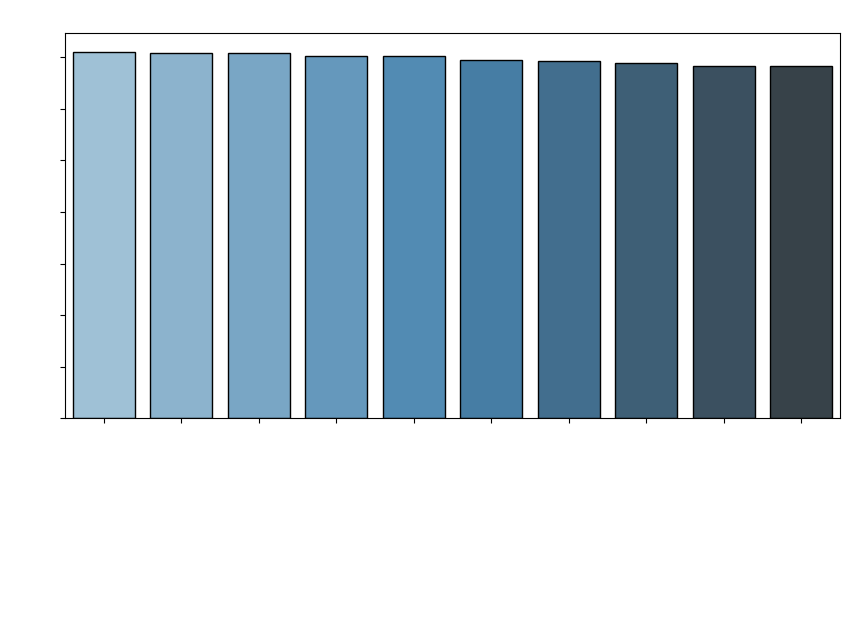

C:\Users\tech\AppData\Local\Temp\ipykernel_2296\479609438.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


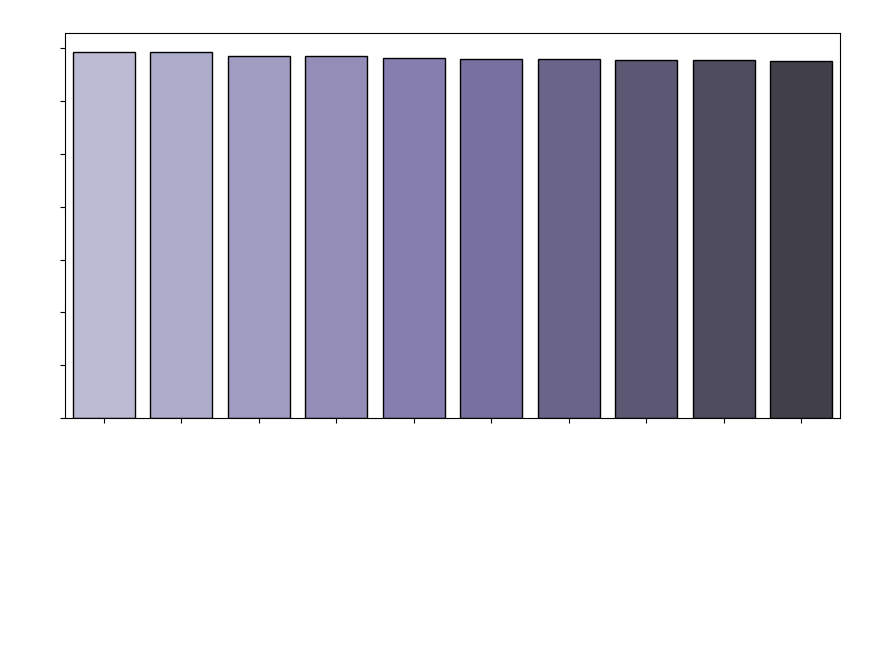

C:\Users\tech\AppData\Local\Temp\ipykernel_2296\479609438.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


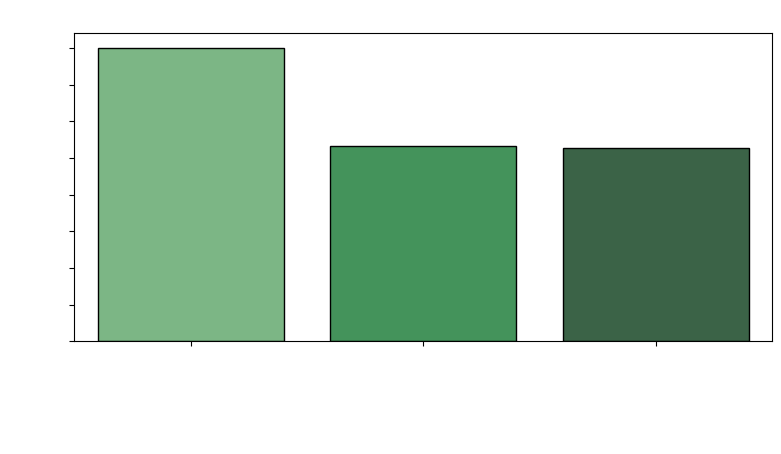

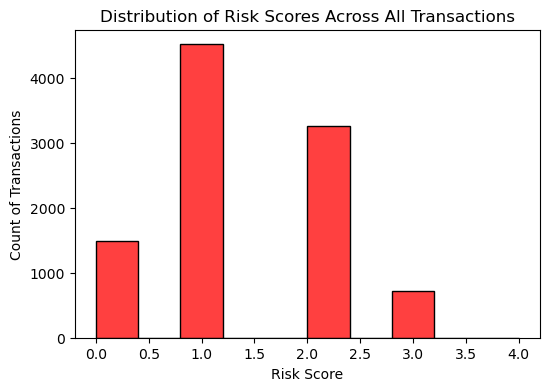

In [11]:
# ----------------------------
# Risk Score Visualizations
# ----------------------------

# ----------------------------
# Risk Score by Pharmacy (Top 10)
# ----------------------------
plt.figure(figsize=(10, 5), facecolor="none")
top_pharmacies = df_fe.groupby("Pharmacy")["risk_score"].mean().sort_values(ascending=False).head(10).index
sns.barplot(
    data=df_fe[df_fe["Pharmacy"].isin(top_pharmacies)], 
    x="Pharmacy", y="risk_score", 
    estimator="mean", errorbar=None, 
    order=top_pharmacies, palette="Blues_d", edgecolor="black"
)
plt.title("Top 10 Pharmacies by Average Risk Score", color="white", fontsize=14, fontweight="bold")
plt.xlabel("Pharmacy", color="white", fontsize=12, fontweight="bold")
plt.ylabel("Avg Risk Score", color="white", fontsize=12, fontweight="bold")
plt.xticks(rotation=45, color="white", fontsize=10, fontweight="bold")
plt.yticks(color="white", fontsize=10, fontweight="bold")
plt.savefig("Risk_score_by_pharmacy.png", dpi=300, bbox_inches="tight", transparent=True)
plt.show()

# ----------------------------
# Risk Score by Supplier (Top 10)
# ----------------------------
plt.figure(figsize=(10, 5), facecolor="none")
top_suppliers = df_fe.groupby("Supplier_Name")["risk_score"].mean().sort_values(ascending=False).head(10).index
sns.barplot(
    data=df_fe[df_fe["Supplier_Name"].isin(top_suppliers)], 
    x="Supplier_Name", y="risk_score", 
    estimator="mean", errorbar=None, 
    order=top_suppliers, palette="Purples_d", edgecolor="black"
)
plt.title("Top 10 Suppliers by Average Risk Score", color="white", fontsize=14, fontweight="bold")
plt.xlabel("Supplier", color="white", fontsize=12, fontweight="bold")
plt.ylabel("Avg Risk Score", color="white", fontsize=12, fontweight="bold")
plt.xticks(rotation=45, color="white", fontsize=10, fontweight="bold")
plt.yticks(color="white", fontsize=10, fontweight="bold")
plt.savefig("Risk_scores_by_suppliers.png", dpi=300, bbox_inches="tight", transparent=True)
plt.show()

# ----------------------------
# Risk Score by Location
# ----------------------------
plt.figure(figsize=(9, 4), facecolor="none")
sns.barplot(
    data=df_fe, x="Location", y="risk_score", 
    estimator="mean", errorbar=None, 
    order=df_fe.groupby("Location")["risk_score"].mean().sort_values(ascending=False).index,
    palette="Greens_d", edgecolor="black"
)
plt.title("Average Risk Score by Location", color="white", fontsize=14, fontweight="bold")
plt.xlabel("Location", color="white", fontsize=12, fontweight="bold")
plt.ylabel("Avg Risk Score", color="white", fontsize=12, fontweight="bold")
plt.xticks(rotation=90, color="white", fontsize=10, fontweight="bold")
plt.yticks(color="white", fontsize=10, fontweight="bold")
plt.savefig("Risk_score_by_locations.png", dpi=300, bbox_inches="tight", transparent=True)
plt.show()


# Distribution of Risk Scores Overall
plt.figure(figsize=(6, 4))
sns.histplot(df_fe["risk_score"], bins=10, kde=False, color="red")
plt.title("Distribution of Risk Scores Across All Transactions")
plt.xlabel("Risk Score")
plt.ylabel("Count of Transactions")
plt.savefig("Overal disribution of risk scores.png", dpi=300, bbox_inches="tight")
plt.show()


In [4]:
df_fe['risk_score'].head(10)

0    2
1    2
2    2
3    2
4    3
5    2
6    2
7    0
8    0
9    0
Name: risk_score, dtype: int32

In [5]:
df_fe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9998 entries, 0 to 9997
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Date                  9998 non-null   datetime64[ns]
 1   Pharmacy              9998 non-null   object        
 2   Location              9998 non-null   object        
 3   Drug                  9998 non-null   object        
 4   Brand                 9998 non-null   object        
 5   Price                 9998 non-null   float64       
 6   Quantity              9998 non-null   float64       
 7   Supplier_Name         9998 non-null   object        
 8   Batch_Number          9998 non-null   object        
 9   Expiry_Date           9998 non-null   datetime64[ns]
 10  Sales_Channel         9998 non-null   object        
 11  Drug_Form             9998 non-null   object        
 12  pharmacy_total_sales  9998 non-null   float64       
 13  pharmacy_avg_price

In [6]:
print(df_fe[['Pharmacy', 'Drug', 'Brand', 'pharmacy_total_sales', 'pharmacy_avg_price']].head(10))

                     Pharmacy           Drug        Brand  \
0                    Ryan PLC    Amoxicillin  HealthFirst   
1      Baker, Mason and White    Amoxicillin  HealthFirst   
2  Watts, Robinson and Nguyen    Paracetamol      BioCare   
3                 Harrell LLC    Amoxicillin     MediPlus   
4                    Ryan PLC    Chloroquine     MediPlus   
5           Williams and Sons  Ciprofloxacin      BioCare   
6   Arroyo, Miller and Tucker    Chloroquine  HealthFirst   
7                 Allen-Allen    Amoxicillin     MediPlus   
8                 Smith-Bowen      Ibuprofen  PharmaTrust   
9                Garcia-James        Coartem  PharmaTrust   

   pharmacy_total_sales  pharmacy_avg_price  
0                9077.0         2528.396444  
1                8870.0         2566.575800  
2               10233.0         2613.152332  
3               10645.0         2453.682670  
4                9077.0         2528.396444  
5               10187.0         2580.299314  
6     

In [8]:
# ========================================
# Anomaly Detection Modeling
# ========================================
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM

# -------------------------
# 1. Define feature groups
# -------------------------
categorical_cols = ["Pharmacy", "Location", "Drug", "Brand", "Supplier_Name", "Sales_Channel", "Drug_Form"]
numeric_cols = [
    "Price", "Quantity", "pharmacy_total_sales", "pharmacy_avg_price", "brand_avg_price",
    "supplier_rare_ratio", "days_to_expiry", "risk_score"
]
binary_flag_cols = ["unusual_discount", "rare_brand_flag", "suspicious_channel", "sales_spike_flag", "near_expiry"]

all_features = numeric_cols + binary_flag_cols + categorical_cols

# -------------------------
# 2. Preprocessor
# -------------------------
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_cols + binary_flag_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_cols)
    ],
    remainder="drop"
)

# -------------------------
# 3. Isolation Forest
# -------------------------
iso_pipe = Pipeline([
    ("pre", preprocessor),
    ("model", IsolationForest(n_estimators=300, contamination=0.02, random_state=42))
])
iso_pipe.fit(df_fe)
df_fe["iso_score"] = iso_pipe.decision_function(df_fe)  # higher = normal
df_fe["iso_flag"] = (iso_pipe.predict(df_fe) == -1).astype(int)

# -------------------------
# 4. Local Outlier Factor
# -------------------------
lof_pipe = Pipeline([
    ("pre", preprocessor),
    ("model", LocalOutlierFactor(n_neighbors=35, contamination=0.02, novelty=False))
])
# LOF does not support predict on pipeline directly for training set
X_trans = preprocessor.fit_transform(df_fe)
lof_model = LocalOutlierFactor(n_neighbors=35, contamination=0.02)
lof_flags = lof_model.fit_predict(X_trans)
df_fe["lof_flag"] = (lof_flags == -1).astype(int)
df_fe["lof_score"] = -lof_model.negative_outlier_factor_

# -------------------------
# 5. Optional One-Class SVM
# -------------------------
svm_pipe = Pipeline([
    ("pre", preprocessor),
    ("model", OneClassSVM(kernel="rbf", nu=0.02, gamma="scale"))
])
svm_pipe.fit(df_fe)
df_fe["svm_score"] = svm_pipe.decision_function(df_fe)
df_fe["svm_flag"] = (svm_pipe.predict(df_fe) == -1).astype(int)

# -------------------------
# 6. Ensemble (Majority Vote)
# -------------------------
flags_stack = np.vstack([df_fe["iso_flag"], df_fe["lof_flag"], df_fe["svm_flag"]]).T
df_fe["ensemble_flag"] = (flags_stack.sum(axis=1) >= 2).astype(int)

# -------------------------
# 7. Summary of flagged %
# -------------------------
summary = {
    "Isolation Forest": df_fe["iso_flag"].mean(),
    "Local Outlier Factor": df_fe["lof_flag"].mean(),
    "One-Class SVM": df_fe["svm_flag"].mean(),
    "Ensemble Majority": df_fe["ensemble_flag"].mean()
}
print("Flagged Transaction Rates (% of total):")
for k, v in summary.items():
    print(f"{k}: {v*100:.2f}%")

# Save for later visualization or dashboard
df_fe.to_csv("pharma_anomaly_scored.csv", index=False)
print("✅ Scored dataset saved to pharma_anomaly_scored.csv")


Flagged Transaction Rates (% of total):
Isolation Forest: 2.00%
Local Outlier Factor: 2.00%
One-Class SVM: 2.21%
Ensemble Majority: 1.30%
✅ Scored dataset saved to pharma_anomaly_scored.csv


In [11]:
from typing import Dict

def risk_scoring(df: pd.DataFrame, anomaly_col: str = "ensemble_flag") -> Dict[str, pd.DataFrame]:
    """Aggregate anomalies and risk scores by Pharmacy, Supplier, and Brand."""

    # Ensure we have a transaction_id (fallback to index if missing)
    if "transaction_id" not in df.columns:
        df = df.reset_index().rename(columns={"index": "transaction_id"})

    # By Pharmacy
    pharmacy_risk = df.groupby("Pharmacy").agg(
        total_tx=("transaction_id", "count"),
        anomalies=(anomaly_col, "sum"),
        avg_risk_score=("risk_score", "mean")
    )
    pharmacy_risk["anomaly_rate"] = pharmacy_risk["anomalies"] / pharmacy_risk["total_tx"]
    pharmacy_risk = pharmacy_risk.sort_values("anomaly_rate", ascending=False)

    # By Supplier
    supplier_risk = df.groupby("Supplier_Name").agg(
        total_tx=("transaction_id", "count"),
        anomalies=(anomaly_col, "sum"),
        avg_risk_score=("risk_score", "mean")
    )
    supplier_risk["anomaly_rate"] = supplier_risk["anomalies"] / supplier_risk["total_tx"]
    supplier_risk = supplier_risk.sort_values("anomaly_rate", ascending=False)

    # By Brand
    brand_risk = df.groupby("Brand").agg(
        total_tx=("transaction_id", "count"),
        anomalies=(anomaly_col, "sum"),
        avg_risk_score=("risk_score", "mean")
    )
    brand_risk["anomaly_rate"] = brand_risk["anomalies"] / brand_risk["total_tx"]
    brand_risk = brand_risk.sort_values("anomaly_rate", ascending=False)

    return {
        "pharmacy_risk": pharmacy_risk,
        "supplier_risk": supplier_risk,
        "brand_risk": brand_risk
    }

# Example usage after anomaly detection
risk_results = risk_scoring(df_fe, anomaly_col="iso_flag")
print("=== Pharmacy Risk ===")
print(risk_results["pharmacy_risk"].head(10))


=== Pharmacy Risk ===
                           total_tx  anomalies  avg_risk_score  anomaly_rate
Pharmacy                                                                    
Garcia-James                    227         37        1.334802      0.162996
Rodriguez-Graham                213         22        1.417840      0.103286
Ross, Robinson and Bright       208         17        1.375000      0.081731
Rodriguez LLC                   215         12        1.344186      0.055814
Anderson Group                  175          9        1.280000      0.051429
Harrell LLC                     206          8        1.412621      0.038835
Allen-Allen                     199          7        1.402010      0.035176
George Group                    181          6        1.320442      0.033149
Gray-Mayo                       205          6        1.282927      0.029268
Burton Ltd                      215          6        1.358140      0.027907
